## Tópicos Especiais em Inteligência Artificial

## Classificação de mãos de poquer com Deep Neural Network (DNN)

Neste trabalho, utilizaremos o Poker Hand Data Set disponível no repositório de datasets da UCI. Este é um conjunto de dados multivariado que contém instâncias de mãos de baralho padrão, utilizado para classificar a categoria da mão de um jogador: 0 (Nothin in hand) até 9 (Royal flush). O dataset completo contém 1.025.010 amostras, mas para esta atividade utilizaremos um subconjunto de 25.010 amostras.  

O modelo recebe 10 atributos de entrada (características das 5 cartas) e 1 atributo de saída (classe da mão):

1. S1: Naipe da carta #1 (1-4: Copas, Espadas, Ouros, Paus)

2. C1: Valor da carta #1 (1-13: Ás, 2, 3, ..., Valete, Dama, Rei)

3. S2: Naipe da carta #2

4. C2: Valor da carta #2

5. S3: Naipe da carta #3

6. C3: Valor da carta #3

7. S4: Naipe da carta #4

8. C4: Valor da carta #4

9. S5: Naipe da carta #5

10. C5: Valor da carta #5

[SAÍDA] Classe: Classificação da mão (0 a 9, onde 0 é "Nada" e 9 é "Royal Flush")

Metodologia da classificação binária:
* Entrada (30 bits): Cada uma das 5 cartas é representada por 6 bits (2 bits para o Naipe e 4 bits para o Valor).

   * Naipes: Ouros (00), Paus (01), Copas (10), Espadas (11).

    * Valores: Ás (0000) até Rei (1100).

* Saída (4 bits): A classe da mão de pôquer é representada por um vetor binário de 4 bits (ex: Nada = 0000, Par = 0001, ..., Royal Flush = 1001).

## 1. Preparação do ambiente

In [1]:
#funcao para deixar o jupyter com celulas preenchendo a tela toda
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#importacao de bibliotecas

#para exportar o requiriments
import subprocess
import sys

#bibliotecas para trabalhar com dados e graficos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

#bibliotecas do scikit-learn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split #divisao dos conjuntos
from sklearn.metrics import confusion_matrix

#biblioteca para exportacoes e importacoes de arquivos
from joblib import dump, load #gera, exporta e usa (salva no HD)

#biblioteca para implementar uma barra de progresso
import progressbar

#biblioteca para tocar sons
import pygame

#bibliotecas para deep learning
import tensorflow.keras 
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LayerNormalization, BatchNormalization, Flatten, Dense, Reshape, Dropout

from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import BinaryCrossentropy

#bibliotecas para plotar graficos do keras
import pydot as pyd
from tensorflow.keras.utils import plot_model, model_to_dot
tensorflow.keras.utils.pydot = pyd

<frozen importlib._bootstrap>:241: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.
/home/victor/anaconda3/envs/dl_tf/lib/python3.11/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


pygame 2.6.1 (SDL 2.32.54, Python 3.11.14)
Hello from the pygame community. https://www.pygame.org/contribute.html


2026-01-08 08:59:50.539031: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-08 08:59:50.660327: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-08 08:59:50.660351: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-08 08:59:50.683209: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-08 08:59:50.717237: I tensorflow/core/platform/cpu_feature_guar

In [4]:
import tensorflow as tf
import keras
print("Versão do Keras: ", keras.__version__)
print("Versão do TensorFlow:", tf.__version__)
print("GPUs disponíveis:", len(tf.config.list_physical_devices('GPU')) > 0)
print("GPU: ", tf.config.list_physical_devices('GPU'))

Versão do Keras:  2.15.0
Versão do TensorFlow: 2.15.0
GPUs disponíveis: True
GPU:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
#rotina para exportação da lista de pacotes
def exportaRequirements():
    try:
        resultado = subprocess.run([sys.executable, '-m', 'pip', 'freeze'], #executando uma consulta a todas as bib do ambiente e guradando
                                capture_output = True, #dentro de resultado
                                text = True,
                                check = True)
        
        with open('requirements.txt', 'w') as f:
            f.write(resultado.stdout) #escrevendo as bib dentro desse arquivo

        print('Arquivo exportado com sucesso!')
    except subprocess.CalledProcessError as e:
        print(f"Deu erro:{e}")

exportaRequirements()

Arquivo exportado com sucesso!


## 2. Importação do dataset

In [ ]:
#cria um nome para cada coluna no dataset
col_names = ['naipe1', 'valor1',
             'naipe2', 'valor2',
             'naipe3', 'valor3',
             'naipe4', 'valor4',
             'naipe5', 'valor5',
             'classe_mao']

#importacao do dataset
data = pd.read_csv('dataset_poquer/pokerhand_dataset.csv', skiprows=1, names=col_names)

#converte tudo para numero
data = data.astype(float)

#converte o codigo do diagnostico
data = data.assign(diagnostico=data['diagnostico'].replace({2: 0, 4:1})) #a coluna diagnostico onde tem 2 passa a ser 0 e 4 vira 1

#nomeia as entradas e saidas
x_names = data.columns[:-1].tolist() #pega todas as colunas (:) menos a última (-1)
y_names = data.columns[-1:].tolist() #pega a última coluna


In [6]:
data

,espessura,tam_celula,forma_celula,adesao,tam_epitelial,nucleos_nus,cromatina,nucleos_normais,mitoses,diagnostico
0,5.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,0.0
1,5.0,4.0,4.0,5.0,7.0,10.0,3.0,2.0,1.0,0.0
2,3.0,1.0,1.0,1.0,2.0,2.0,3.0,1.0,1.0,0.0
3,6.0,8.0,8.0,1.0,3.0,4.0,3.0,7.0,1.0,0.0
4,4.0,1.0,1.0,3.0,2.0,1.0,3.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
694,3.0,1.0,1.0,1.0,3.0,2.0,1.0,1.0,1.0,0.0
695,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,0.0
696,5.0,10.0,10.0,3.0,7.0,3.0,8.0,10.0,2.0,1.0
697,4.0,8.0,6.0,4.0,3.0,4.0,10.0,6.0,1.0,1.0


## 3. Configuração do Experimento

In [ ]:
#realizar interpolacao de dados (criacao de dados sinteticos - nesse caso vizinho mais proximo)
interp_exec = True

#realizar deteccao e substituicao de outliers
outliers_exec = True

#realizar normalizacao de dados
normalization_exec = True

#realizar escalonamento de dados
scale_exec = True

#exportar os datasets tratados
export_frames = False

#gerar um novo modelo ou usar um pronto
new_model = True

## 4. Análise de Dados

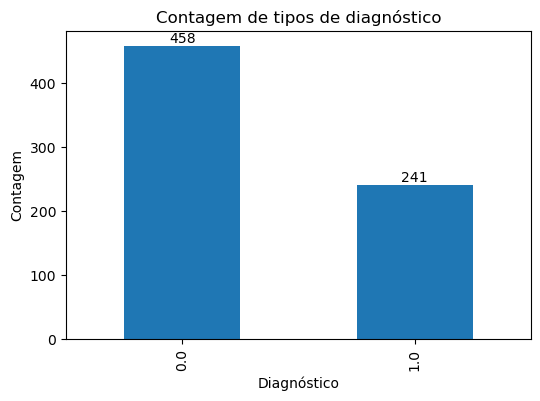

In [8]:
#contagem de diagnosticos
diag_counts = data['diagnostico'].value_counts()

#plota grafico de barra
plt.figure(figsize=(6,4))
diag_counts.plot(kind='bar')
plt.xlabel('Diagnóstico')
plt.ylabel('Contagem')
plt.title('Contagem de tipos de diagnóstico')

#adiciona os rotulos
for i, count in enumerate(diag_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

### 4.1 Sumarização estatística

In [9]:
def sumarizacao(data):
    stats = []

    for column in x_names:
        values = data[column]

        maximum = round(values.max(), 2) #arredonda o valor maximo da coluna no momento com duas casas decimais
        minimum = round(values.min(), 2)
        mean = round(values.mean(), 2)
        median = round(values.median(), 2)
        std = round(values.std(), 2)
        stats.append([column, maximum, minimum, mean, median, std])

    headers = ['Coluna', 'Máximo', 'Mínimo', 'Média', 'Mediana', 'Desvio Padrão']

    table = tabulate(stats, headers, tablefmt='pipe')
    print(table)

sumarizacao(data)

| Coluna          |   Máximo |   Mínimo |   Média |   Mediana |   Desvio Padrão |
|:----------------|---------:|---------:|--------:|----------:|----------------:|
| espessura       |       10 |        1 |    4.42 |         4 |            2.82 |
| tam_celula      |       10 |        1 |    3.13 |         1 |            3.05 |
| forma_celula    |       10 |        1 |    3.21 |         1 |            2.97 |
| adesao          |       10 |        1 |    2.81 |         1 |            2.86 |
| tam_epitelial   |       10 |        1 |    3.22 |         2 |            2.21 |
| nucleos_nus     |       10 |        1 |    3.54 |         1 |            3.64 |
| cromatina       |       10 |        1 |    3.44 |         3 |            2.44 |
| nucleos_normais |       10 |        1 |    2.87 |         1 |            3.05 |
| mitoses         |       10 |        1 |    1.59 |         1 |            1.72 |


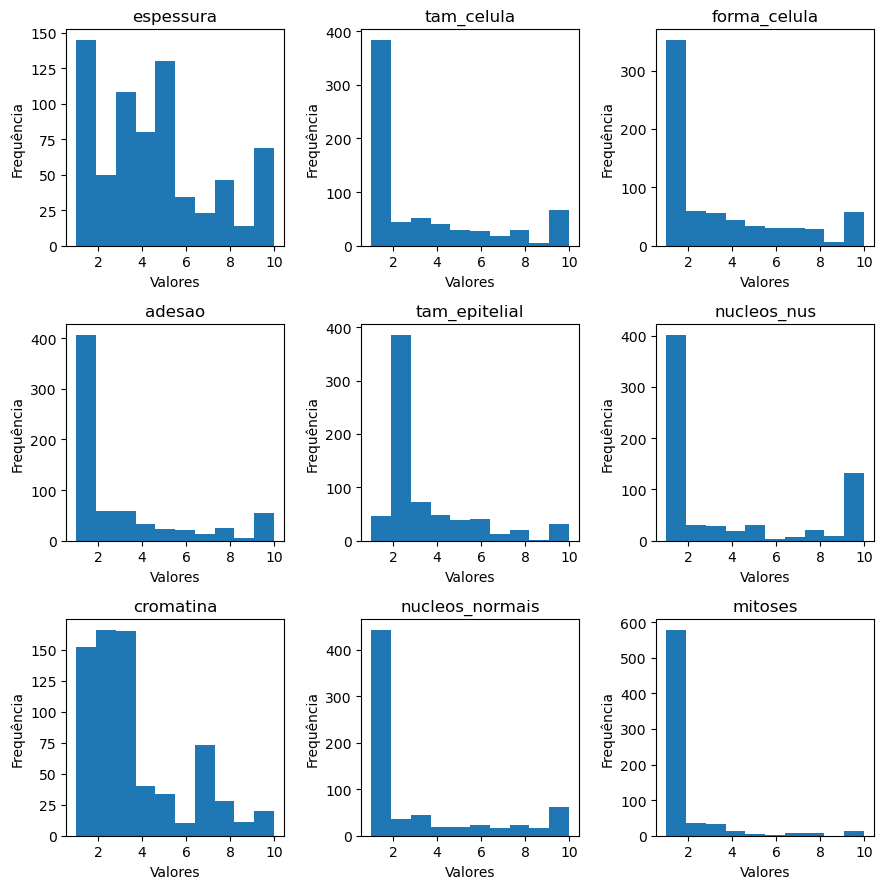

In [10]:
fig, axs = plt.subplots(3, 3, figsize=(9, 9), tight_layout=True)

#pltar o grafico para cada coluna de entrada
for i, column in enumerate(x_names):
    row = i // 3 #linha atual
    col = i % 3 #coluna atual
    axs[row, col].hist(data[column], bins=10) #bins -> tamanho da classe do histograma
    axs[row, col].set_title(column)
    axs[row, col].set_xlabel('Valores')
    axs[row, col].set_ylabel('Frequência')

plt.show()

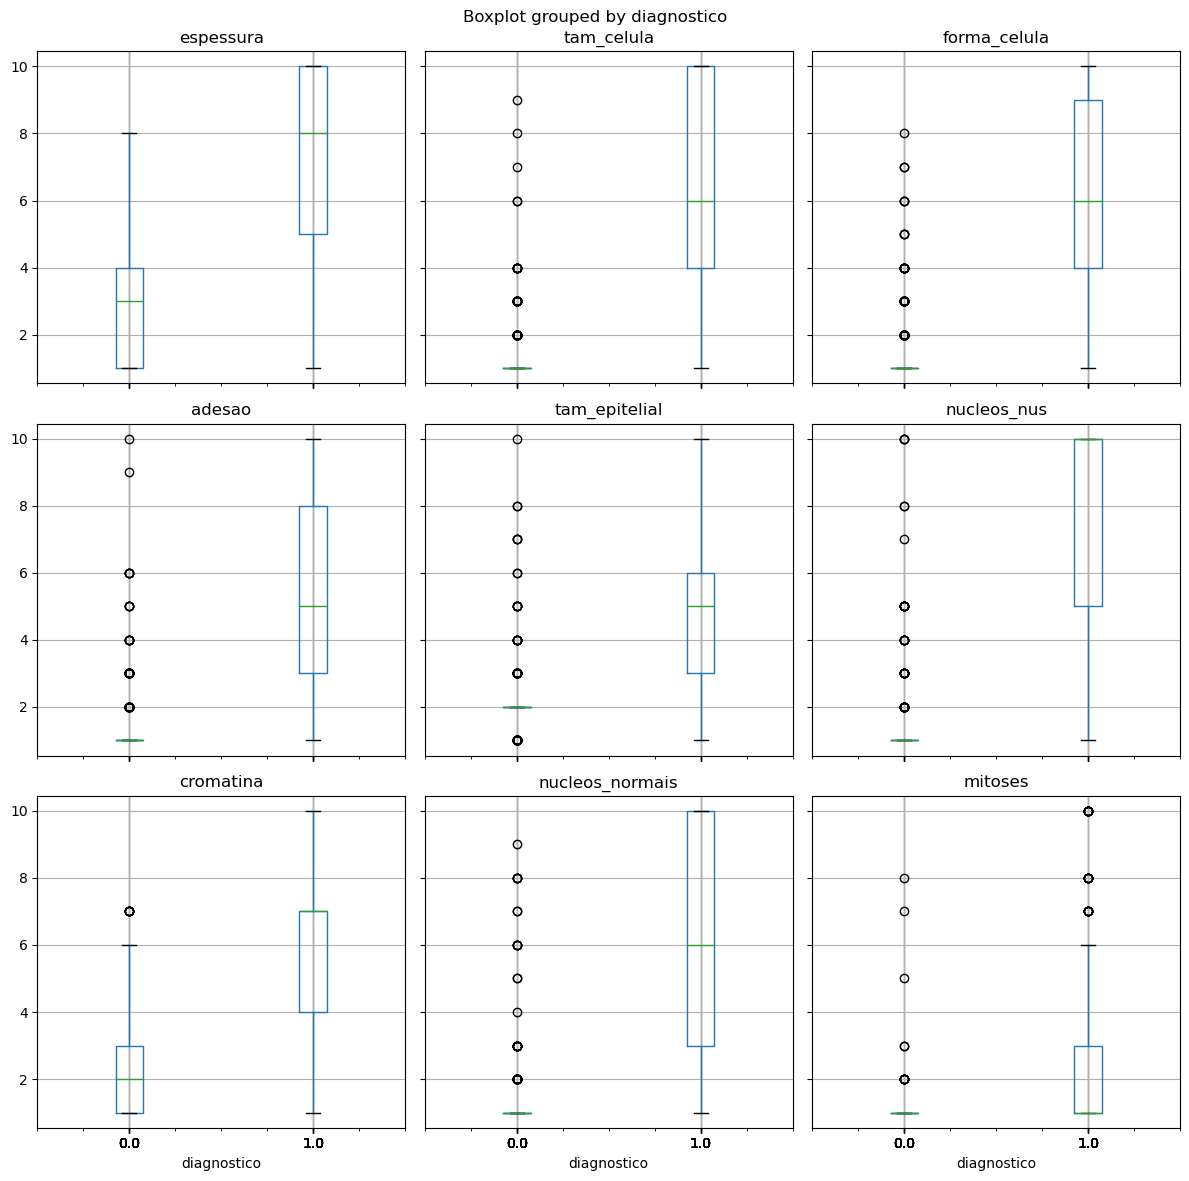

In [11]:
#boxplot para ver se tem outliers (IQR)
data.boxplot(column=x_names, by='diagnostico', figsize=(12, 12)) #by = separar por diagnostico
plt.tight_layout()
plt.show()

### 4.2 Deteccção de dados faltantes e interpolação

In [12]:
missing_counts = data.isnull().sum()
print("Total de dados faltantes por atributo (coluna):\n", missing_counts)

Total de dados faltantes por atributo (coluna):
 espessura           0
tam_celula          0
forma_celula        0
adesao              0
tam_epitelial       0
nucleos_nus        16
cromatina           0
nucleos_normais     0
mitoses             0
diagnostico         0
dtype: int64


In [13]:
#interpola os dados faltantes (vizinho mais proximo)
def interpolacao(data):
    if data.isnull().values.any(): #se existir pelo menos um dado faltante
        points_inds_danger = [0, 1, len(data) - 2, len(data) - 1] #tem que existr pelo menos o 1º, 2º, penultimo e ultimo dado para interpolar

        #esse for garante que vai ter numeros nos indices do vetor a cima
        for colname in x_names:
            for ind_danger in points_inds_danger:
                if np.isnan(data[colname].iloc[ind_danger].astype(float)): #converte para float e compara com NaN, se for, entra if
                    data[colname].iloc[ind_danger] = data[colname].mean()
            
            data[colname] = data[colname].interpolate(method='nearest').copy()
    
    return data
            


In [14]:
if interp_exec:
    data = interpolacao(data)

In [15]:
missing_counts = data.isnull().sum()
print("Total de dados faltantes por atributo (coluna):\n", missing_counts)

Total de dados faltantes por atributo (coluna):
 espessura          0
tam_celula         0
forma_celula       0
adesao             0
tam_epitelial      0
nucleos_nus        0
cromatina          0
nucleos_normais    0
mitoses            0
diagnostico        0
dtype: int64


### 4.3 Detecção e substituição de outliers

In [16]:
def getQuantiles(x, margin = 1.5, low = 0.1, high = 0.9):
    
    q1 = x.quantile(low)
    q3 = x.quantile(high)
    iqr = q3 - q1
    fence_low = q1 - (margin * iqr)
    fence_high = q3 + (margin * iqr)

    return [fence_low, fence_high]

def replaceOutliers(serie, m):

    x = serie.copy()

    fences = getQuantiles(x, margin = m)
    bad_inds = x.loc[(x < fences[0]) | (x > fences[1])].index
    x[bad_inds] = np.nan

    outlier_inds_danger = [0, 1, len(serie) - 2, len(serie) - 1]
    for ind_danger in outlier_inds_danger:
        if np.isnan(x.iloc[ind_danger]):
            x[ind_danger] = (fences[0] + fences[1]) / 2 #media dos dois limites


    if x.isnull().values.any(): #se tiver pelo menos um nulo
        x = x.interpolate(method="nearest").copy()
    
    return x


In [17]:
if outliers_exec:
    for col in x_names:
        data[col] = replaceOutliers(data[col], 0)

### 4.4 Aplicando normalização (estabilização de variância)

In [18]:
def normalization(data, method):
    if method == 'asinh':
        return np.arcsinh(data)
    elif method == 'log':
        return np.log(data)
    else:
        return (data - np.mean(data)) / np.std(data)

In [19]:
if normalization_exec:
    for col in x_names:
        data[col] = normalization(data[col], 'mean') 

In [20]:
data

,espessura,tam_celula,forma_celula,adesao,tam_epitelial,nucleos_nus,cromatina,nucleos_normais,mitoses,diagnostico
0,0.481973,-0.653930,-0.706788,-0.582619,-0.620341,-0.696275,0.026555,-0.544156,-0.331584,0.0
1,0.481973,0.728420,0.683582,1.497845,0.953592,1.781250,0.026555,-0.089717,-0.331584,0.0
2,-0.386324,-0.653930,-0.706788,-0.582619,-0.620341,-0.420994,0.026555,-0.544156,-0.331584,0.0
3,0.916122,2.571552,2.537408,-0.582619,0.166625,0.129567,0.026555,2.182474,-0.331584,0.0
4,0.047825,-0.653930,-0.706788,0.457613,-0.620341,-0.696275,0.026555,-0.544156,-0.331584,0.0
...,...,...,...,...,...,...,...,...,...,...
694,-0.386324,-0.653930,-0.706788,-0.582619,0.166625,-0.420994,-1.034124,-0.544156,-0.331584,0.0
695,-0.820473,-0.653930,-0.706788,-0.582619,-0.620341,-0.696275,-1.034124,-0.544156,-0.331584,0.0
696,0.481973,-0.653930,-0.706788,0.457613,-0.620341,-0.145714,-1.034124,-0.544156,1.683871,1.0
697,0.047825,2.571552,1.610495,0.977729,0.166625,0.129567,0.556894,1.728036,-0.331584,1.0


### 4.5 Aplicando escalonamento nos dados

In [21]:
#funcao que cria uma regua com valores minimos e maximos para se usar no escalonamento
def create_support_col(minvalue, maxvalue, sizecol):
    minvalues = [minvalue] * round(sizecol/2)
    maxvalues = [maxvalue] * (sizecol - round(sizecol/2))

    return [*minvalues, *maxvalues]

def minMaxIndividual(df, col, minvalue, maxvalue, rgint):
    serie = df[col].copy()
    
    #cria uma regua com um valor minimo e maximo prviamente determinado
    serie['support'] = create_support_col(minvalue, maxvalue, len(serie))

    #escalona considerando o minimo e o maximo especificado
    tmp = serie.to_numpy().reshape(-1, 1) #nao tem linha e tem 1 coluna

    #cria o objeto de escalonamento
    minMaxScaler = preprocessing.MinMaxScaler(feature_range = rgint).fit(tmp) #vai ajustar o vetor dentro do intervalo

    #cria os dados escalonados
    scaled = minMaxScaler.transform(tmp).reshape(serie.shape[0], serie.shape[1])

    #remove a coluna de suporte e atualiza as colunas escalonadas no dataset
    df[col] = scaled[:, 0:(scaled.shape[1]-1)]

    return df

In [22]:
scale_range = (0, 1)

if scale_exec:
    for col in x_names:
        data = minMaxIndividual(data, [col], np.min(data[col]), np.max(data[col]), scale_range)

In [23]:
sumarizacao(data)

| Coluna          |   Máximo |   Mínimo |   Média |   Mediana |   Desvio Padrão |
|:----------------|---------:|---------:|--------:|----------:|----------------:|
| espessura       |        1 |        0 |    0.36 |      0.38 |            0.29 |
| tam_celula      |        1 |        0 |    0.18 |      0    |            0.27 |
| forma_celula    |        1 |        0 |    0.22 |      0    |            0.31 |
| adesao          |        1 |        0 |    0.16 |      0    |            0.27 |
| tam_epitelial   |        1 |        0 |    0.2  |      0    |            0.32 |
| nucleos_nus     |        1 |        0 |    0.28 |      0    |            0.4  |
| cromatina       |        1 |        0 |    0.32 |      0.33 |            0.31 |
| nucleos_normais |        1 |        0 |    0.15 |      0    |            0.28 |
| mitoses         |        1 |        0 |    0.08 |      0    |            0.25 |


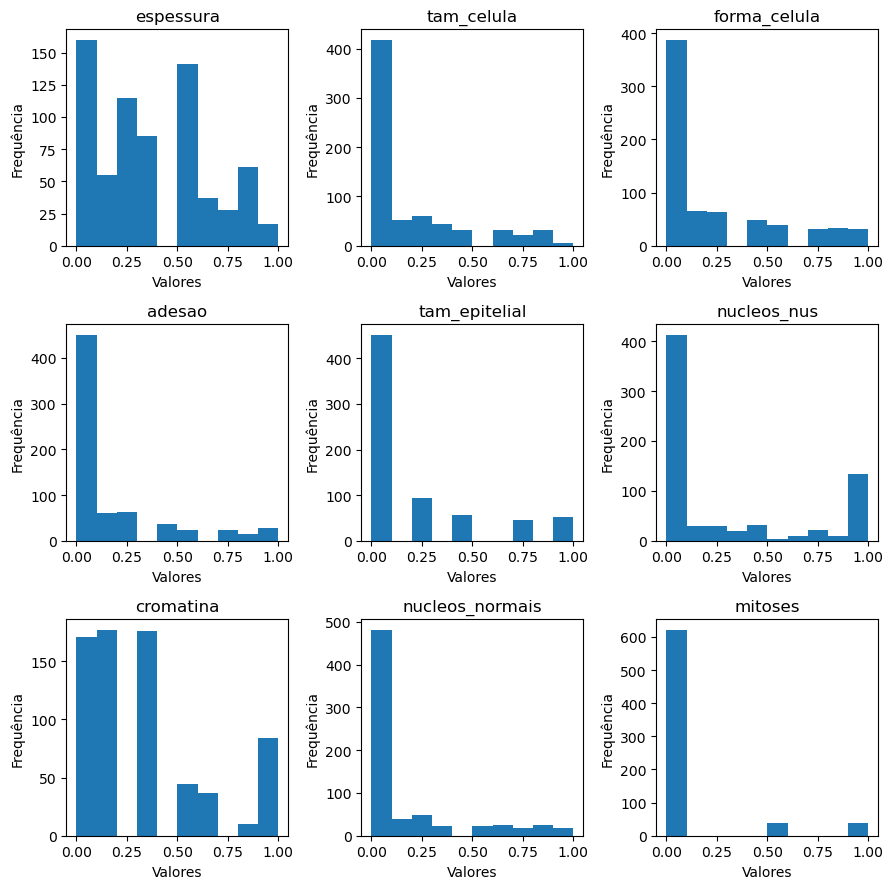

In [24]:
fig, axs = plt.subplots(3, 3, figsize=(9, 9), tight_layout=True)

#pltar o grafico para cada coluna de entrada
for i, column in enumerate(x_names):
    row = i // 3 #linha atual
    col = i % 3 #coluna atual
    axs[row, col].hist(data[column], bins=10) #bins -> tamanho da classe do histograma
    axs[row, col].set_title(column)
    axs[row, col].set_xlabel('Valores')
    axs[row, col].set_ylabel('Frequência')

plt.show()

### 4.6 Exportando ou carregando um dataset tratado

In [25]:
if export_frames:
    bar = progressbar.ProgressBar(maxval = len(data), widgets=[progressbar.Bar("=", "[", "]"), " ", progressbar.Percentage()])
    bar.start()

    x_frames = []
    y_frames = []

    cont = 0
    for ind in range(0, len(data), 1):
        x_frames.append(data.loc[ind, x_names].values) #pegando a linha ind e somente as colunas de entrada
        y_frames.append(data.loc[ind, y_names].values.reshape(-1))

        bar.update(cont + 1)
        cont += 1
    
    x_frames = np.array(x_frames)
    y_frames = np.array(y_frames).reshape(-1, 1)

    dump(x_frames, 'dataset/x_frames.joblib')
    dump(y_frames, 'dataset/y_frames.joblib')

    bar.finish()

else:
    x_frames = load('dataset/x_frames.joblib')
    y_frames = load('dataset/y_frames.joblib')

print(x_frames.shape)
print(y_frames.shape)

(699, 9)
(699, 1)


In [26]:
x_train_val, x_test, y_train_val, y_test = train_test_split(x_frames, y_frames, test_size = 0.3, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size = 0.2, shuffle=True)

print("Treino: ")
print(x_train.shape) #dados das 9 colunas de entrada
print(y_train.shape) #dados da coluna de saida

print("Validação:")
print(x_val.shape) #dados das 9 colunas de entrada
print(y_val.shape) #dados da coluna de saida

print("Teste:")
print(x_test.shape) #dados das 9 colunas de entrada
print(y_test.shape) #dados da coluna de saida

Treino: 
(391, 9)
(391, 1)
Validação:
(98, 9)
(98, 1)
Teste:
(210, 9)
(210, 1)


### 5 Treinamento do medelo

### 5.1 Construção do modelo

In [ ]:
#parametros da rede
act_function = 'sigmoid'
drop = 0.1 #dropout - drogar a rede (durante o treinamento da rede, ele desabilita algumas partes da rede)
#é como se certas partes dos neuronios não sofrem alterações dos pesos durante o backpropagation, isso pode ajudar
#a acessar certas partes do modelo que não foram acessadas, por haver partes com uma concentração de "conhecimento"
#isso ajuda a distribuir esse "conhecimento" (beck das redes)
initializer = tensorflow.keras.initializers.LecunNormal()

#camadas de entrada
inputs = Input(shape = (x_train.shape[1],), dtype='float32') #camade de input() -> forma de como os dados vão entrar na camada (391 exemplos com 9 atributos e 391 exemplos de saida)
#vão entrar 9 atributos e o tamanho de exemplos (linhas, dados) 
#traducao - espere 9 atributos do tipo float com uma quantidade inderteminada de exemplos

#camada 1 - neuronio de camada densa
layer1 = Dense(32, activation=act_function, kernel_initializer= initializer)(inputs) #qtd neuronios, funcao de ativacao, como quer inicializar
#a camada de inputs entra na camada 1 -> layer1(...)(inputs) -- (320 pesos -> 9*32+32) o dropout tambem soma, entao 288+32 (um dropout pra cada neuronio)
layer1 = Dropout(drop)(layer1) #a layer1 vai sofrer um dropout de 10% - ()() = concatenacao, conectar camadas, entrada e saidas

#camada 2
layer2 = Dense(64, activation=act_function, kernel_initializer= initializer)(layer1)
layer2 = Dropout(drop)(layer2) #2112 pesos (32*64+64)

#camada 3
layer3 = Dense(32, activation=act_function, kernel_initializer= initializer)(layer2)
layer3 = Dropout(drop)(layer3) #2080 pesos (32*64)

#camada de saida
outputs = Dense(y_train.shape[1], activation=act_function, kernel_initializer= initializer)(layer3) #32 pesos (32*1)
#qtd parametros total = 4545 (320+2112+2080+32+1)

#geracao do modelo
dnn_breast_cancer = Model(inputs, outputs)

### 5.2 Inspeção do modelo

In [41]:
print(dnn_breast_cancer.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 9)]               0         
                                                                 
 dense_18 (Dense)            (None, 32)                320       
                                                                 
 dropout_13 (Dropout)        (None, 32)                0         
                                                                 
 dense_19 (Dense)            (None, 64)                2112      
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 dense_20 (Dense)            (None, 32)                2080      
                                                                 
 dropout_15 (Dropout)        (None, 32)                0   

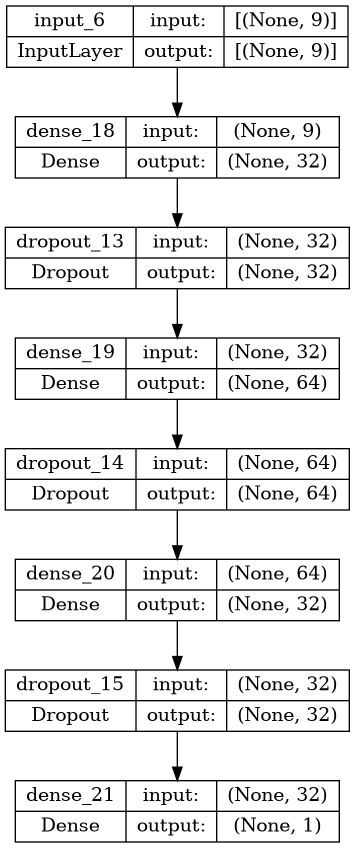

In [42]:
#plotar o modelo
plot_model(dnn_breast_cancer, show_shapes=True, show_layer_names=True, rankdir="TB") #rankdir - orientacao (vertical, horizontal)

### 5.3 Otimização do modelo

In [60]:
if (new_model):
    tensorflow.keras.backend.set_epsilon(1) #limite de 1, o gradiente pode passar de 1 por conta das multiplicacoes
    #entao essa funcao clipa essa parte depois do 1.talcoisa
    opt = Adam(learning_rate=0.0001) #algoritmo de otimizacao adam

    dnn_breast_cancer.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy']) #loss = o calculo do erro
    #metrica boa para classificacao binaria (dois valores nesse caso 0 e 1)
    #accuracy - classificacao (qtd_acertos/total, qtd_erros/total) tem a ver com categoria (faz isso depois da matriz de confusao)

    #objeto de checkpoint
    cp = ModelCheckpoint(
        filepath = 'models/best_weights.h5',
        save_weigths_only = True,
        monitor = 'loss', #a cada epoca mostra a loss na tela
        mode='min', #minimiza ou maximiza o erro
        save_best_only = True)

    es = EarlyStopping(monitor='loss', mode='min', patience=100) #conversao do erro (para de treinar a rede a partir de 100 epocas se o erro nao mudar)

    history = dnn_breast_cancer.fit(
        x_train, y_train, #vc quer que o x_train aprenda a gerar o y_train
        validation_data = (x_val, y_val), #validacao do treino a cima
        epochs = 1000,
        verbose = 1,
        callbacks = [es, cp], #criou dois callbacks - checkpoint e ea
        batch_size = 8, #faz a media do erro com base no batch_size (atualizacao do erro a cada lote de 8 vezes)
        shuffle = False #embaralhar
    ) #comando para treinar a rede
    #traducao - treine o modelo dnn com os seguintes parametros (use os seguintes valores para treino,
    # os seguintes valores para validacao, quantidade de epocas, os callbacks que tem que são cp, ea, tamanho dos lotes
    # que servem para otimizar a quantidade de tempo (calculo do erro so acontece a cada 8) e embaralhamento que é false )


    np.save('models/history_model.npy', history.history)
    dnn_breast_cancer.load_weights('models/best_weights.h5') #carrega os melhores cp e salva no modelo
    dnn_breast_cancer.save('models/dnn_breast_cancer.h5') #salva o modelo

else:
    dnn_breast_cancer = load_model('models/dnn_breast_cancer.h5')

Epoch 1/1000
49/49 [==============================] - 1s 5ms/step - loss: 0.1218 - accuracy: 0.9693 - val_loss: 0.1573 - val_accuracy: 0.9592
Epoch 2/1000
49/49 [==============================] - 0s 3ms/step - loss: 0.1178 - accuracy: 0.9668 - val_loss: 0.1574 - val_accuracy: 0.9592
Epoch 3/1000
 1/49 [..............................] - ETA: 0s - loss: 0.3530 - accuracy: 0.8750

/home/victor/anaconda3/envs/dl_tf/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 0s 3ms/step - loss: 0.1179 - accuracy: 0.9693 - val_loss: 0.1577 - val_accuracy: 0.9592
Epoch 4/1000
49/49 [==============================] - 0s 3ms/step - loss: 0.1204 - accuracy: 0.9642 - val_loss: 0.1573 - val_accuracy: 0.9592
Epoch 5/1000
49/49 [==============================] - 0s 3ms/step - loss: 0.1272 - accuracy: 0.9591 - val_loss: 0.1579 - val_accuracy: 0.9592
Epoch 6/1000
49/49 [==============================] - 0s 4ms/step - loss: 0.1274 - accuracy: 0.9616 - val_loss: 0.1581 - val_accuracy: 0.9592
Epoch 7/1000
49/49 [==============================] - 0s 3ms/step - loss: 0.1171 - accuracy: 0.9668 - val_loss: 0.1580 - val_accuracy: 0.9592
Epoch 8/1000
49/49 [==============================] - 0s 3ms/step - loss: 0.1258 - accuracy: 0.9642 - val_loss: 0.1571 - val_accuracy: 0.9592
Epoch 9/1000
49/49 [==============================] - 0s 3ms/step - loss: 0.1348 - accuracy: 0.9565 - val_loss: 0.1576 - val_accuracy: 0.9592
Epoch 10/1000
49/49

In [43]:
pygame.mixer.init()
arquivo_mp3 = 'support_files/uepa.mp3'
pygame.mixer.music.load(arquivo_mp3)
pygame.mixer.music.play()

while pygame.mixer.music.get_busy():
    continue

print('Sucesso!')

Sucesso!


## 6. Avaliando a Qualidade do treino

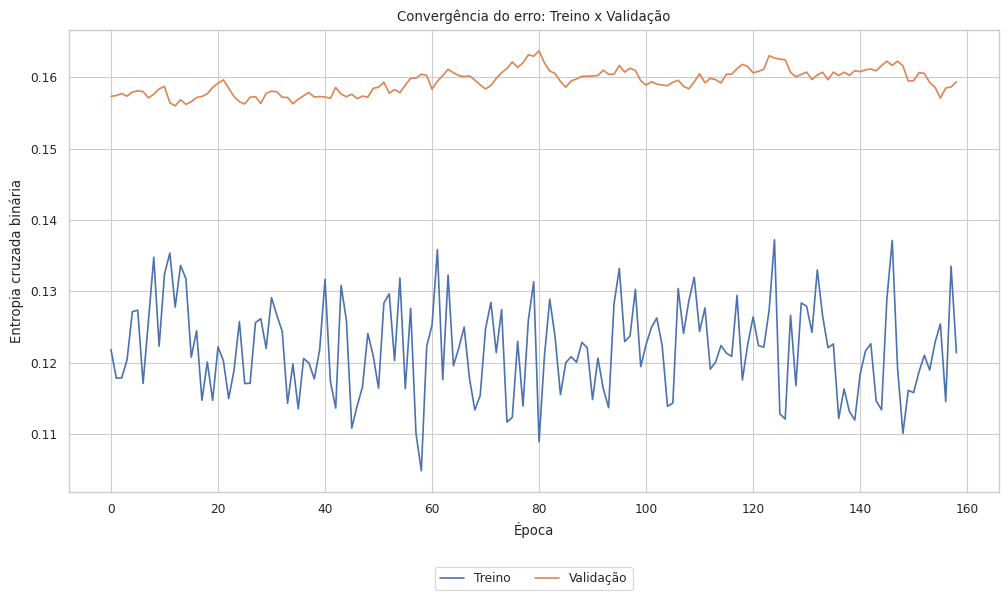

In [61]:
history = np.load('models/history_model.npy', allow_pickle=True).item()

sns.set(rc={'figure.figsize': (12,6)})
sns.set_style('whitegrid')
sns.set_context('paper') #plotar no notebook

train_metric = history['loss'] #metricas que usou para o treino
valid_metric = history['val_loss'] #metricas que usou para validacao
name_metric = 'Entropia cruzada binária'

fig = plt.figure()
plt.plot(train_metric, label='Treino')
plt.plot(valid_metric, label='Validação')
plt.ylabel(name_metric)
plt.xlabel('Época')
plt.title('Convergência do erro: Treino x Validação')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

### 7 Testando as previsões

### 7.1 Gerando as previsões com o modelo treinado

In [62]:
y_hat = dnn_breast_cancer.predict(x_test)
y_hat, y_test = (y_hat > 0.5, y_test > 0.5)

7/7 [==============================] - 0s 1ms/step


### 7.2 Calculando a taxa de acerto com base na matriz de confusão

In [67]:
#calcula a matriz de confusao
cm = confusion_matrix(y_test.tolist(), y_hat.tolist())
print(cm)

[[128   7]
 [  2  73]]


In [66]:
#calculando a taxa de acerto (accuracy)
accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()

accuracy_percent = round(accuracy * 100, 2) #duas casas decimais
print("Taxa de Acerto: {:.2f}%".format(accuracy_percent))

Taxa de Acerto: 95.71%


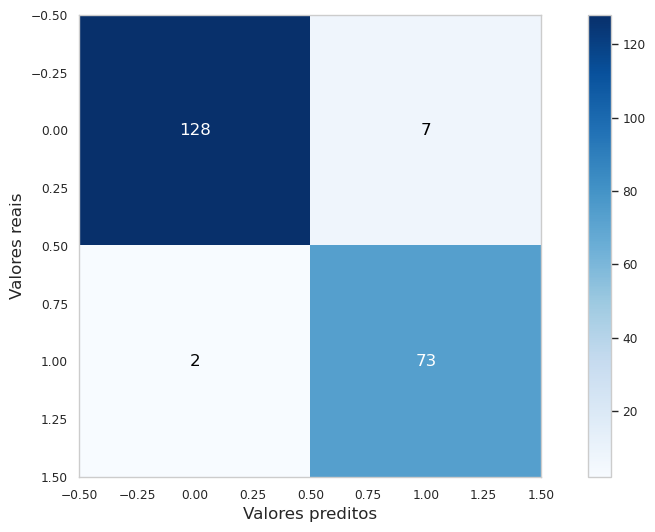

In [65]:
#plot da confusion matrix
plt.grid(False)
plt.imshow(cm, cmap="Blues")
plt.xlabel('Valores preditos', fontsize=12)
plt.ylabel('Valores reais', fontsize=12)

treshold = cm.max()/2

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        color = 'white' if cm[i,j] > treshold else 'black'
        plt.text(j,i, str(cm[i,j]), ha='center', va='center', color=color, fontsize=12)

plt.colorbar()
plt.show()

In [102]:
#TESTE FOMAÇ DE CLASSIFICACAO
#selecionar pacientes aleatorios e fazer a previsao

#separar indices por diagnostico
indices_benignos = np.where(y_test == 0)[0]
indices_malignos = np.where(y_test == 1)[0]

#sortear alguns indices
idx_benignos = np.random.choice(indices_benignos)
idx_malignos = np.random.choice(indices_malignos)

#selecionar um paciente
paciente_benigno = x_test[idx_benignos:idx_benignos + 1]
paciente_maligno = x_test[idx_malignos:idx_malignos + 1]

#fazer previsoes
pred_benigno = dnn_breast_cancer.predict(paciente_benigno, verbose=0)[0][0]
pred_maligno = dnn_breast_cancer.predict(paciente_maligno, verbose=0)[0][0]

#pega o valor real para comparar com o predito
real_benigno = y_test[idx_benignos][0]
real_maligno = y_test[idx_malignos][0]

#classificacao dos preditos
classe_pred_benigno = 'maligno' if pred_benigno > 0.5 else 'benigno'
classe_pred_maligno = 'maligno' if pred_maligno > 0.5 else 'benigno'

#classificacao
acertou_benigno = (pred_benigno <= 0.5 and real_benigno == 0)
acertou_maligno = (pred_maligno > 0.5 and real_maligno == 1)

#exibir resuultado
print("PACIENTE COM CANCER BENIGNO (real)")
print(f'Probabilidade prevista: {pred_benigno:.4f}')
print(f'Classificação prevista: {classe_pred_benigno}')
print(f"Resultado: {'acertou' if acertou_benigno else 'errou'}")

print('='*60)

print("PACIENTE COM CANCER MALIGNO (real)")
print(f'Probabilidade prevista: {pred_maligno:.4f}')
print(f'Classificação prevista: {classe_pred_maligno}')
print(f"Resultado: {'acertou' if acertou_maligno else 'errou'}")


PACIENTE COM CANCER BENIGNO (real)
Probabilidade prevista: 0.0020
Classificação prevista: benigno
Resultado: acertou
PACIENTE COM CANCER MALIGNO (real)
Probabilidade prevista: 0.9131
Classificação prevista: maligno
Resultado: acertou
